In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Function to perform train-test split and complete missing data using regression
def complete_missing_data(df, target_station):
    # Drop rows with NaN values in the target station
    # Create a copy of the dropped rows
    dropped_df = df[df.isna().any(axis=1)]

    # Filtrar las filas donde target_station es NaN
    target_nan_df = df[df[target_station].isna()]

    # Filtrar las filas donde el resto de las columnas no son NaN
    target_nan_df_non_nan_other_columns_df = target_nan_df[target_nan_df.drop(columns=[target_station]).notna().all(axis=1)]

    # Obtener las filas que están en dropped_df pero no en target_nan_df_non_nan_other_columns_df
    rows_to_keep = dropped_df.index.difference(target_nan_df_non_nan_other_columns_df.index)
    dropped_df_not_in_target_nan = dropped_df.loc[rows_to_keep]

    # Drop the rows with NaN values in 'target_station' from the original DataFrame
    remaining_df = df.dropna()
    
    # Train-test split (70% train, 30% test)
    train_df, test_df = train_test_split(remaining_df, test_size=0.3, random_state=42)

    # Initialize regression models
    linear_reg = LinearRegression()
    random_forest_reg = RandomForestRegressor()

    # Define performance metric (RMSE in this example)
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Train models on the training set
    X_train = train_df.drop([target_station, 'Fecha'], axis=1)
    y_train = train_df[target_station]
    linear_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)

    # Evaluate models on the test set
    X_test = test_df.drop([target_station, 'Fecha'], axis=1)
    y_test = test_df[target_station]
    linear_reg_rmse = root_mean_squared_error(y_test, linear_reg.predict(X_test))
    random_forest_rmse = root_mean_squared_error(y_test, random_forest_reg.predict(X_test))

    # Choose the best model based on performance (lower RMSE in this case)
    if linear_reg_rmse < random_forest_rmse:
        selected_model = linear_reg
        selected_model_name = 'Linear Regression'
        selected_model_rmse = linear_reg_rmse
    else:
        selected_model = random_forest_reg
        selected_model_name = 'Random Forest'
        selected_model_rmse = random_forest_rmse

    # Use the selected model to complete missing values in the target station
    feature_names = X_train.columns
    for index, row in target_nan_df_non_nan_other_columns_df.iterrows():
        if pd.isnull(row[target_station]):
            X_pred = row.drop([target_station, 'Fecha']).values.reshape(1, -1)
            X_pred_df = pd.DataFrame(X_pred, columns=feature_names)
            predicted_value = selected_model.predict(X_pred_df)[0]

            # Check if the predicted value is negative or close to 0
            if predicted_value < 0 or np.isclose(predicted_value, 0):
                predicted_value = 0
                
            target_nan_df_non_nan_other_columns_df.loc[index, target_station] = np.round(predicted_value,2)

    # Merge them back together
    merged_df = pd.concat([target_nan_df_non_nan_other_columns_df, remaining_df,dropped_df_not_in_target_nan], ignore_index=True)
    merged_df.sort_values(by='Fecha', inplace=True)
    return merged_df, selected_model_name, selected_model_rmse


In [2]:
obs=pd.read_csv('../data/precp/gauge.csv',sep=',')
#obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)
#obs['Fecha'] = pd.to_datetime(obs['Fecha'])
#obs.set_index('Fecha',inplace=True)
obs.head()

,Fecha,chusis,chalaco,huamarca,huancabamba,miraflores
0,1980-01-01,0.0,0.0,0.4,2.1,0.0
1,1980-01-02,0.0,0.0,0.0,0.0,0.0
2,1980-01-03,0.0,0.0,0.0,1.5,0.0
3,1980-01-04,0.0,0.0,0.0,0.0,0.0
4,1980-01-05,0.0,0.0,0.0,0.0,0.0


# Remover años El Niño

In [3]:
def remove_years(df, years_to_remove):
    # Ensure 'Fecha' is in datetime format
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    # Filter out the rows where the year of the 'Fecha' column is in the years_to_remove list
    df_filtered = df[~df['Fecha'].dt.year.isin(years_to_remove)]
    
    return df_filtered


# List of years to remove
years_to_remove = [1982,1983,1998,2017]

# Remove the specified years
obs = remove_years(obs, years_to_remove)

# Display the result
obs.head(10)

,Fecha,chusis,chalaco,huamarca,huancabamba,miraflores
0,1980-01-01,0.0,0.0,0.4,2.1,0.0
1,1980-01-02,0.0,0.0,0.0,0.0,0.0
2,1980-01-03,0.0,0.0,0.0,1.5,0.0
3,1980-01-04,0.0,0.0,0.0,0.0,0.0
4,1980-01-05,0.0,0.0,0.0,0.0,0.0
5,1980-01-06,0.0,0.0,0.0,0.0,0.0
6,1980-01-07,0.0,2.2,0.0,0.0,0.0
7,1980-01-08,0.0,0.0,0.0,0.0,0.0
8,1980-01-09,0.0,0.0,0.2,0.0,0.0
9,1980-01-10,0.0,0.0,0.3,0.0,0.0


In [4]:
nan_percentages = obs.isna().mean() * 100
# Sort columns based on NaN percentages in ascending order
ordered_columns = nan_percentages.sort_values().index.tolist()
ordered_columns.pop(0)

resultados = {}
resultados['Gauge'] = []
resultados['Selected Model'] = []
resultados['RMSE'] = []
for idx,gauge in enumerate(ordered_columns):
    if idx == 0:
        completed_df, model_name, model_rmse = complete_missing_data(obs, gauge)
    else:
        completed_df, model_name, model_rmse = complete_missing_data(completed_df, gauge)
    print(f"Selected Model: {model_name}")
    print(f"RMSE: {model_rmse}")
    print(completed_df)
    resultados['Gauge'].append(gauge)
    resultados['Selected Model'].append(model_name)
    resultados['RMSE'].append(model_rmse)


Selected Model: Linear Regression
RMSE: 3.472366421482689
           Fecha  chusis  chalaco  huamarca  huancabamba  miraflores
69    1980-01-01     0.0      0.0       0.4          2.1         0.0
70    1980-01-02     0.0      0.0       0.0          0.0         0.0
71    1980-01-03     0.0      0.0       0.0          1.5         0.0
72    1980-01-04     0.0      0.0       0.0          0.0         0.0
73    1980-01-05     0.0      0.0       0.0          0.0         0.0
...          ...     ...      ...       ...          ...         ...
9279  2016-12-27     0.0      4.5       3.2          0.8         0.0
9280  2016-12-28     0.0      7.0       8.2         21.6         1.8
9281  2016-12-29     0.0      0.0       0.5          0.0         0.0
9282  2016-12-30     0.0      0.5       1.9          0.0         0.0
12419 2016-12-31     0.0      NaN       4.0          0.0         NaN

[12420 rows x 6 columns]
Selected Model: Linear Regression
RMSE: 4.517050196907498
           Fecha  chusis  chal

In [5]:
completed_df.isna().mean() * 100

Fecha          0.000000
chusis         6.594203
chalaco        0.483092
huamarca       2.987118
huancabamba    1.352657
miraflores     5.370370
dtype: float64

In [6]:
obs.isna().mean() * 100

Fecha           0.000000
chusis         18.526570
chalaco         2.447665
huamarca        4.404187
huancabamba     1.908213
miraflores      8.164251
dtype: float64

In [7]:
pd.DataFrame(resultados)

,Gauge,Selected Model,RMSE
0,huancabamba,Linear Regression,3.472366
1,chalaco,Linear Regression,4.517050
2,huamarca,Linear Regression,6.189773
3,miraflores,Linear Regression,1.930607
4,chusis,Linear Regression,0.807538


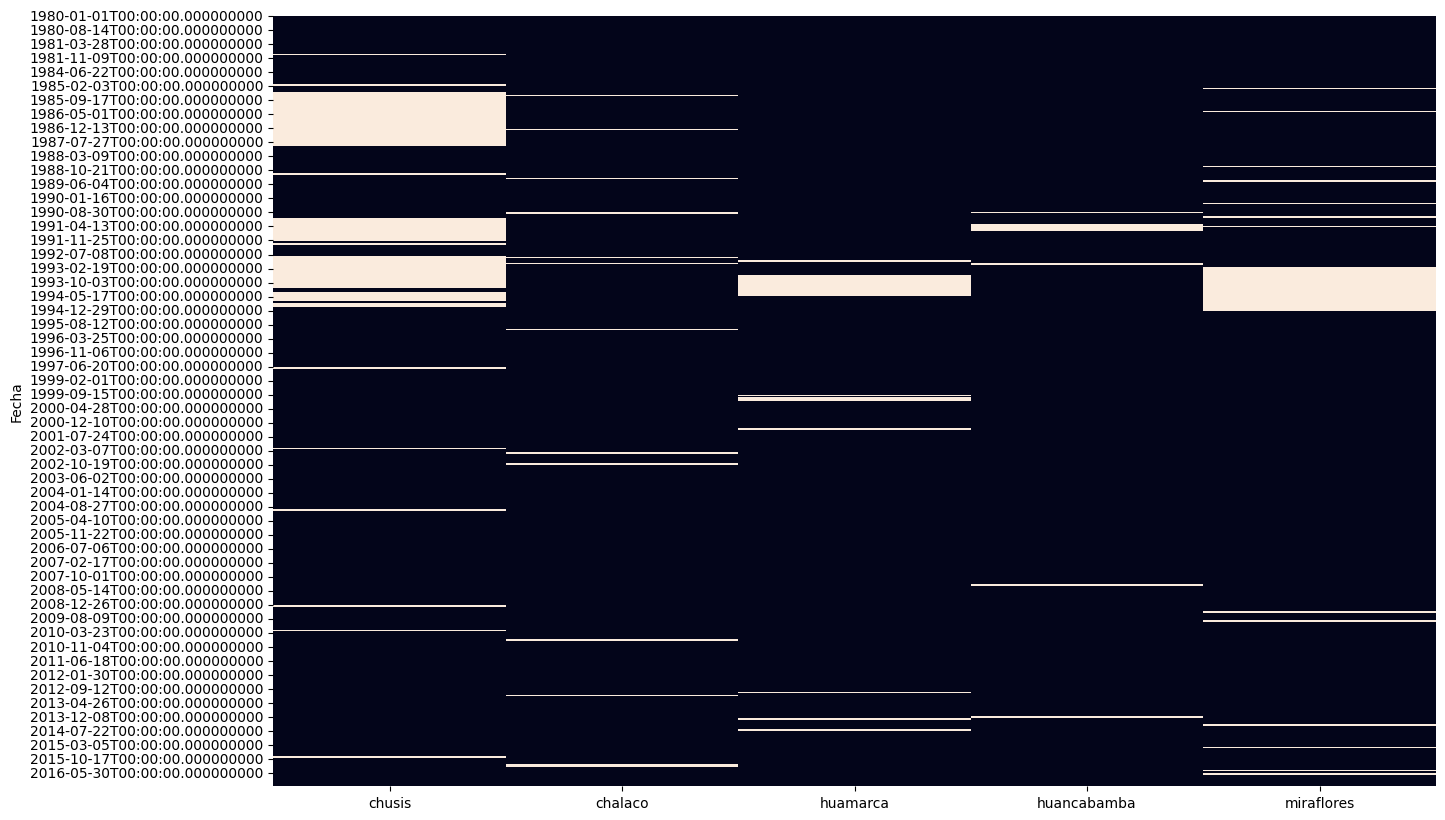

In [8]:
obs['Fecha'] = pd.to_datetime(obs['Fecha'])
obs.set_index('Fecha',inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(obs.isnull(), cbar=False)
plt.show()

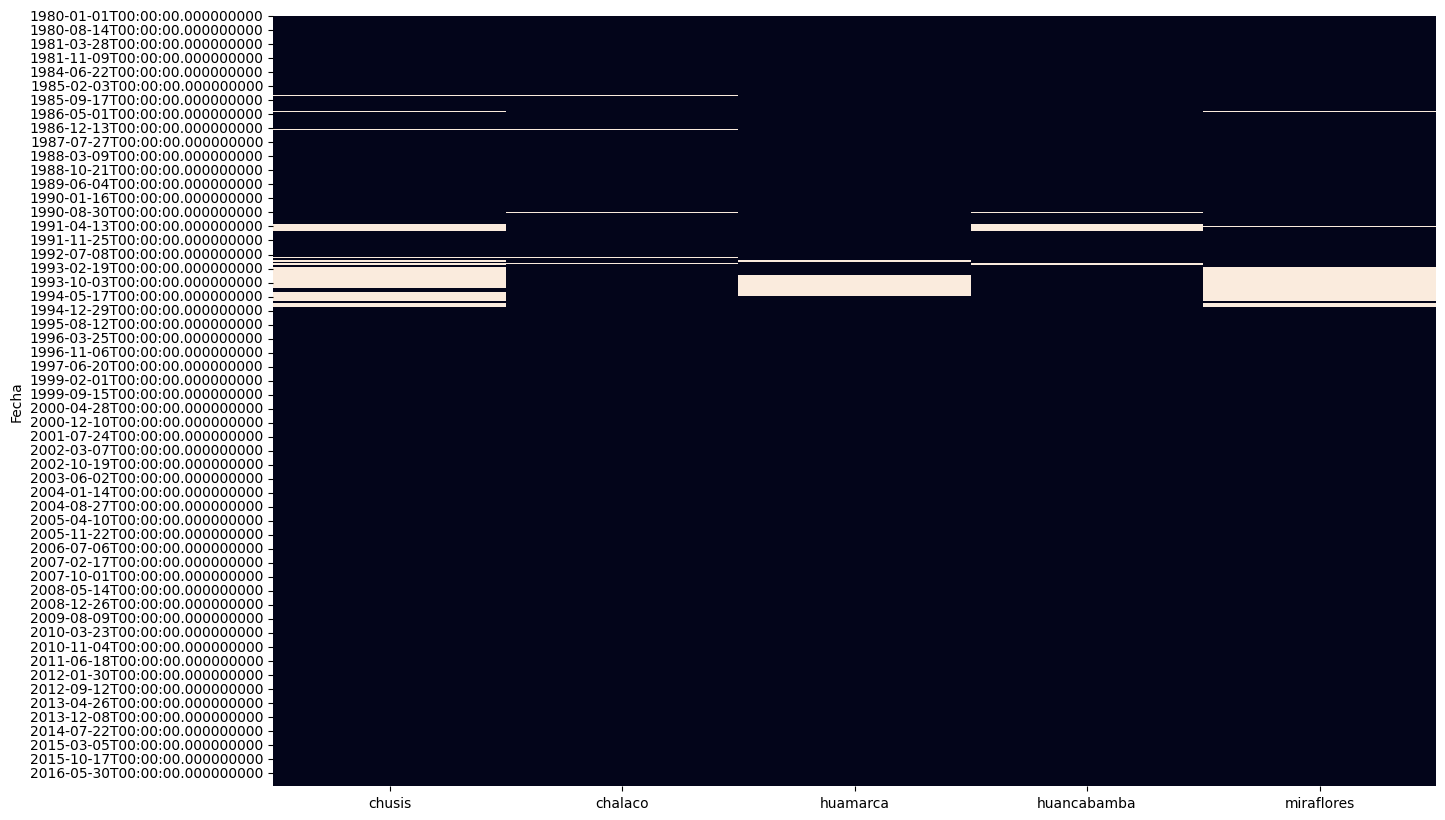

In [9]:
completed_df['Fecha'] = pd.to_datetime(completed_df['Fecha'])
completed_df.set_index('Fecha',inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(completed_df.isnull(), cbar=False)
plt.show()

In [10]:
completed_df.corr()

,chusis,chalaco,huamarca,huancabamba,miraflores
chusis,1.000000,0.233152,0.213977,0.123479,0.706444
chalaco,0.233152,1.000000,0.681927,0.460554,0.275544
huamarca,0.213977,0.681927,1.000000,0.497791,0.254919
huancabamba,0.123479,0.460554,0.497791,1.000000,0.131431
miraflores,0.706444,0.275544,0.254919,0.131431,1.000000


chalaco <-> huarmaca
huarmaca y chalaco ->huancabamba 

In [11]:
def train_and_complete(data, predictors, target):
    """
    Train a linear regression model to predict the target using the predictors.
    Removes NA values from the target and predictor columns, trains the model,
    and fills in the NA values in the target column with the model predictions.
    
    :param data: pd.DataFrame, the input data
    :param predictors: list of str, the column names of the predictors
    :param target: str, the column name of the target variable
    :return: pd.DataFrame, the data with NA values in the target column filled
    """
    # Copy the data to avoid modifying the original DataFrame
    df = data.copy()

    # Remove rows where the target or any predictors are NA
    train_data = df.dropna(subset=[target] + predictors)

    # Train the linear regression model
    X_train = train_data[predictors].values
    y_train = train_data[target].values
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Separate the rows where the target is NA (for prediction)
    predict_data = df[df[target].isna()]

    # Ensure predictor columns have no NA values for prediction rows
    predict_data = predict_data.dropna(subset=predictors)

    if not predict_data.empty:
        # Predict the missing values
        X_predict = predict_data[predictors].values
        y_predict = model.predict(X_predict)

        # Fill in the missing values in the target column
        df.loc[predict_data.index, target] = np.round(y_predict,2)

    return df, model

In [12]:
# Linear Regression 1: chalaco -> huamarca
completed_df, model_1 = train_and_complete(completed_df, ['chalaco'], 'huamarca')
completed_df, model_2 = train_and_complete(completed_df, ['huamarca'], 'chalaco')
completed_df, model_3 = train_and_complete(completed_df, ['huamarca','chalaco'], 'huancabamba')
completed_df, model_3 = train_and_complete(completed_df, ['huamarca','chalaco'], 'chusis')
completed_df, model_3 = train_and_complete(completed_df, ['chusis'], 'miraflores')

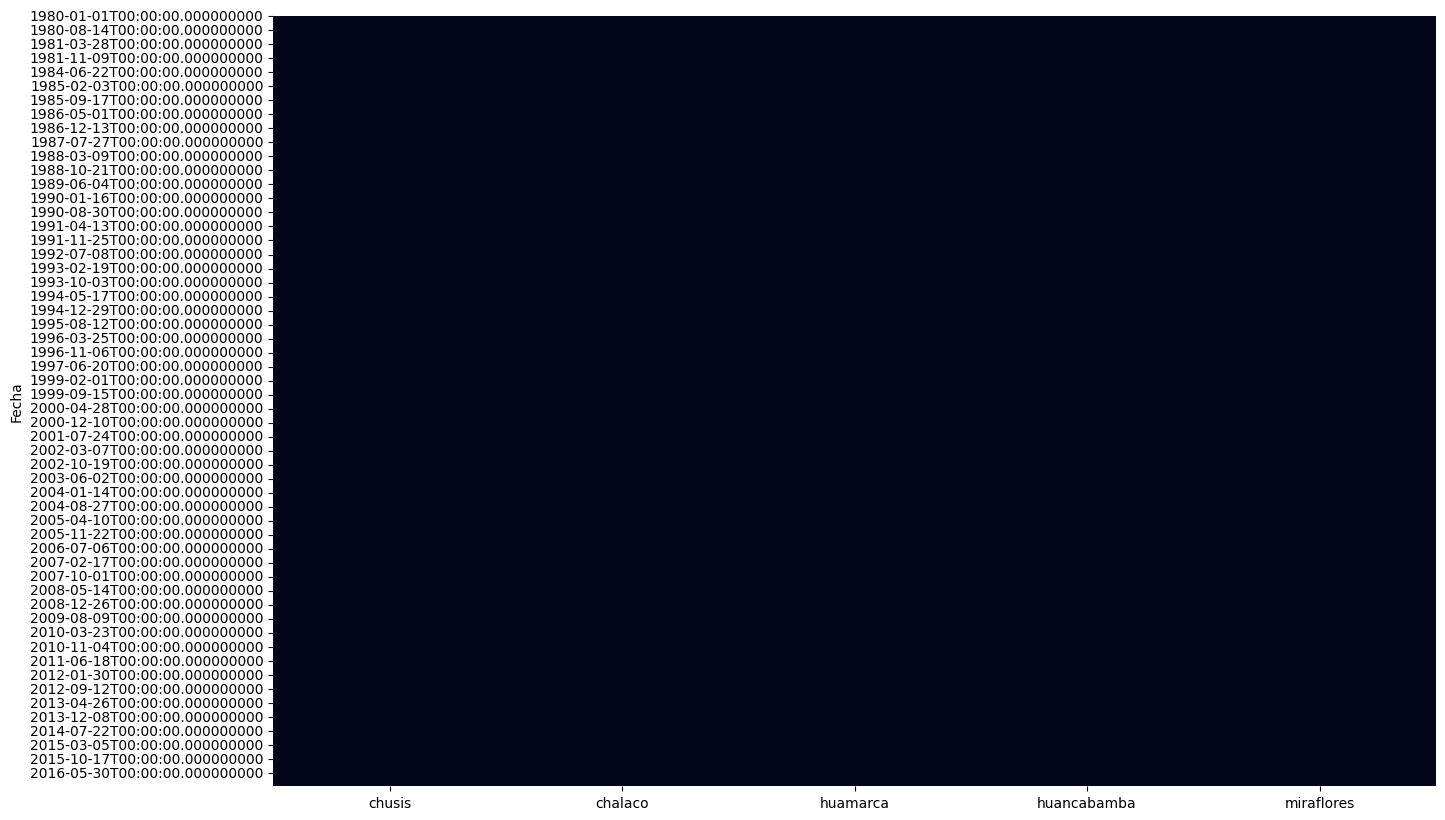

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(completed_df.isnull(), cbar=False)
plt.show()

In [14]:
completed_df.to_csv('../data/precp/completada/gauge_completada.csv',index=True)